In [1]:
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
import os
import random
import numpy as np


from tqdm import tqdm 

from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold

2025-03-14 15:31:41.864694: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-14 15:31:41.886398: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-14 15:31:41.893048: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-14 15:31:41.977995: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
num_classes = 1
k = 5


IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

DATA_PATH = 'data2/'

data_ids = next(os.walk(DATA_PATH+'/image'))[2]
data_ids = sorted(data_ids,  key=lambda x: int(x.split('.')[0]))
X = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR']= 'cuda_malloc_async'


In [3]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):   
    path = DATA_PATH
    img = imread(path + '/image/' + id_, as_gray=True)[:,:]
    img = img.reshape(img.shape[0], img.shape[1], IMG_CHANNELS)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    
    mask = imread(path + 'label/' + id_, as_gray=True)
    mask = (mask >= 1)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
    y[n] = mask
    #plt.axis("off")
    #imshow(y[n])
    #plt.show()

Resizing training images and masks


100%|█████████████████████████████████████████████████████████████████████████████████| 490/490 [00:13<00:00, 37.44it/s]


In [4]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'Predicted mask (UNet)', 'Predicted mask (UNet++)', 'Predicted mask (UNet3Plus)']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
    plt.axis('off')
  plt.show()

In [6]:
fold = 3
kf = KFold(n_splits=k, shuffle=True, random_state=28)
for i, (train_ind, test_ind) in enumerate(kf.split(X)):
    if i == (fold-1):
        X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]
        break
        
modelU = tf.keras.models.load_model('UNET 5-fold models/model_'+str(fold)+'fold.keras')
modelUP = tf.keras.models.load_model('UNETPlusPlus 5-fold models/model_'+str(fold)+'fold.keras')
modelU3 = tf.keras.models.load_model('UNET3Plus 5-fold models/model_'+str(fold)+'fold.keras')

2024-11-14 11:10:23.117434: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 11:10:23.253899: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 11:10:23.253948: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 11:10:23.255939: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 11:10:23.255973: I external/local_xla/xla/stream_executor

In [15]:
fold = 3

modelU = tf.keras.models.load_model('UNET 5-fold models/model_'+str(fold)+'fold.keras')
modelUP = tf.keras.models.load_model('UNETPlusPlus 5-fold models/model_'+str(fold)+'fold.keras')
modelU3 = tf.keras.models.load_model('UNET3Plus 5-fold models/model_'+str(fold)+'fold.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


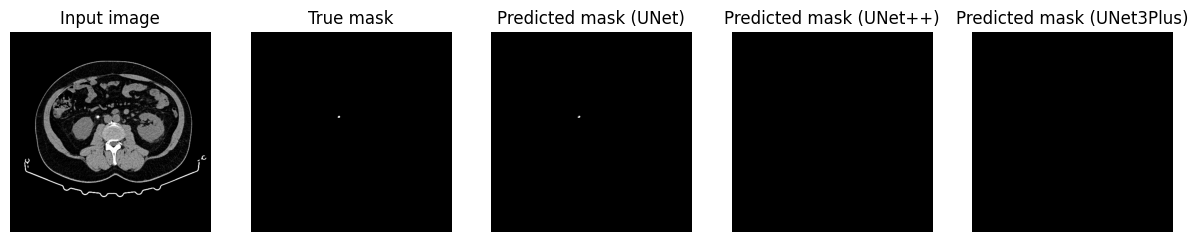

Dice U-Net: 0.92
Dice U-Net++: 0.0
Dice U-Net3+: 0.0


In [35]:
#i = random.randint(0, len(X))
i = 211
sample_image = X[i]
sample_mask = y[i]

predictionU = modelU.predict(sample_image[tf.newaxis, ...])[0]
predicted_maskU = (predictionU > 0.5).astype(np.uint8)
predictionUP = modelUP.predict(sample_image[tf.newaxis, ...])[0]
predicted_maskUP = (predictionUP > 0.5).astype(np.uint8)
predictionU3 = modelU3.predict(sample_image[tf.newaxis, ...])[0]
predicted_maskU3 = (predictionU3 > 0.5).astype(np.uint8)
display([sample_image, sample_mask, predicted_maskU, predicted_maskUP, predicted_maskU3])


cv2.imwrite("Result Images/original"+str(i)+".png", sample_image)
cv2.imwrite("Result Images/groundtruth"+str(i)+".png", (sample_mask > 0.5).astype(np.uint8)*255)
cv2.imwrite("Result Images/UNetResult"+str(i)+".png", predicted_maskU*255)
cv2.imwrite("Result Images/UNetPlusResult"+str(i)+".png", predicted_maskUP*255)
cv2.imwrite("Result Images/UNet3PlusResult"+str(i)+".png", predicted_maskU3*255)

sample_mask = y[i].astype(np.uint8).flatten()
predicted_maskU = predicted_maskU.flatten()
predicted_maskUP = predicted_maskUP.flatten()
predicted_maskU3 = predicted_maskU3.flatten()


print("Dice U-Net: "+ str((2*jaccard_score(sample_mask, predicted_maskU))/(1+jaccard_score(sample_mask, predicted_maskU))))
print("Dice U-Net++: "+ str((2*jaccard_score(sample_mask, predicted_maskUP))/(1+jaccard_score(sample_mask, predicted_maskUP))))
print("Dice U-Net3+: "+ str((2*jaccard_score(sample_mask, predicted_maskU3))/(1+jaccard_score(sample_mask, predicted_maskU3))))

In [29]:
totalDiceU = []
totalDiceUP = []
totalDiceU3 = []

ureter_stone = range(211, 219)
for i in range(211, 219): 
    #i = 216
    sample_image = X[i]
    sample_mask = y[i]
    
    predictionU = modelU.predict(sample_image[tf.newaxis, ...])[0]
    predicted_maskU = (predictionU > 0.5).astype(np.uint8)
    predictionUP = modelUP.predict(sample_image[tf.newaxis, ...])[0]
    predicted_maskUP = (predictionUP > 0.5).astype(np.uint8)
    predictionU3 = modelU3.predict(sample_image[tf.newaxis, ...])[0]
    predicted_maskU3 = (predictionU3 > 0.5).astype(np.uint8)
    #display([sample_image, sample_mask, predicted_maskU, predicted_maskUP, predicted_maskU3])
    
    
    cv2.imwrite("Result2/"+str(i)+".png", predicted_maskU*255)
    
    sample_mask = y[i].astype(np.uint8).flatten()
    predicted_maskU = predicted_maskU.flatten()
    predicted_maskUP = predicted_maskUP.flatten()
    predicted_maskU3 = predicted_maskU3.flatten()
    
    DiceU = (2*jaccard_score(sample_mask, predicted_maskU))/(1+jaccard_score(sample_mask, predicted_maskU))
    DiceUP = (2*jaccard_score(sample_mask, predicted_maskUP))/(1+jaccard_score(sample_mask, predicted_maskUP))
    DiceU3 = (2*jaccard_score(sample_mask, predicted_maskU3))/(1+jaccard_score(sample_mask, predicted_maskU3))

    if(DiceU != 0):
        totalDiceU.append(DiceU)
    if(DiceUP != 0):
        totalDiceUP.append(DiceUP)
    if(DiceU3 != 0):
        totalDiceU3.append(DiceU3)
    
    #print("Dice U-Net: "+ str(DiceU))
    #print("Dice U-Net++: "+ str(DiceUP))
    #print("Dice U-Net3+: "+ str(DiceU3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [30]:
np.mean(totalDiceU)

0.9520417010085513

In [31]:
np.mean(totalDiceUP)

0.933871843541655

In [32]:
np.mean(totalDiceU3)

/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mbouzon/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan